### This Transfer learning model works for three classes (ENCL, COL, No light)

In [18]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(49) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(49)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
os.chdir('/content/gdrive/MyDrive')
!pwd

/content/gdrive/MyDrive


In [19]:
#COLN #114, 99, 175,185

from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/gdrive/MyDrive/Classes"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150; 
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 49,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

        




Found 3403 files belonging to 3 classes.
Using 2723 files for training.
Found 3403 files belonging to 3 classes.
Using 680 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['COLN-20-Pitch', 'Enclosed Streetlights', 'Non-Streetlights-30-Pitch']


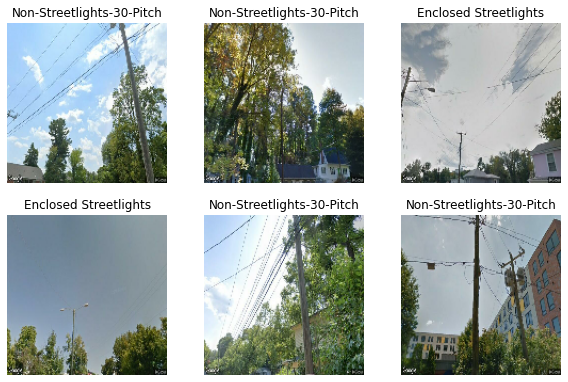

In [14]:
# View 6 images
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [21]:
## State Variables 
n_classes=3
dataset_size=3403
#train_size=
#valid_size=

In [22]:
#Preprocess function for resizing images for Densenet deep learning model
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet.preprocess_input (resized_image)
    return image, label

In [11]:
# Data augmentation function for Resnet50
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image) 
    return image, label

In [ ]:
# Second Data augmentation function for Resnet50
def data_augmentation2(image, label):
    image = tf.image.central_crop(image, 0.90)
    image = tf.image.per_image_standardization(image)
    return image, label

In [24]:
#Preprocessing and functions applied
train_ds = train_ds.shuffle(1000).repeat(20) ### Check on Repeat
train_set = train_ds.map(preprocess).prefetch(1)
valid_set = validation_ds.map(preprocess).prefetch(1)

In [25]:
train_set

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [23]:
valid_set

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [26]:
base_model = keras.applications.ResNet50(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

In [27]:
## Adam LR .001, no augmentation  .80 (3 classes)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10)

Epoch 1/10
79/79 [==============================] - 651s 6s/step - loss: 0.7824 - accuracy: 0.6398 - val_loss: 0.5823 - val_accuracy: 0.7125
Epoch 2/10
79/79 [==============================] - 484s 6s/step - loss: 0.4726 - accuracy: 0.7911 - val_loss: 0.5280 - val_accuracy: 0.7479
Epoch 3/10
79/79 [==============================] - 477s 6s/step - loss: 0.4334 - accuracy: 0.8189 - val_loss: 0.5096 - val_accuracy: 0.7625
Epoch 4/10
79/79 [==============================] - 475s 6s/step - loss: 0.4205 - accuracy: 0.8141 - val_loss: 0.5337 - val_accuracy: 0.7542
Epoch 5/10
79/79 [==============================] - 480s 6s/step - loss: 0.3955 - accuracy: 0.8405 - val_loss: 0.4994 - val_accuracy: 0.7646
Epoch 6/10
79/79 [==============================] - 479s 6s/step - loss: 0.3931 - accuracy: 0.8406 - val_loss: 0.4662 - val_accuracy: 0.8021
Epoch 7/10
79/79 [==============================] - 467s 6s/step - loss: 0.3790 - accuracy: 0.8484 - val_loss: 0.4619 - val_accuracy: 0.8021
Epoch 8/10
79

In [ ]:
## With Augmentation: Random-Flip - Left to Right .80
## Adam LR .005

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10)

Epoch 1/10
79/79 [==============================] - 627s 6s/step - loss: 0.3000 - accuracy: 0.8755 - val_loss: 0.6251 - val_accuracy: 0.7604
Epoch 2/10
79/79 [==============================] - 476s 6s/step - loss: 0.3119 - accuracy: 0.8774 - val_loss: 0.5959 - val_accuracy: 0.7708
Epoch 3/10
79/79 [==============================] - 485s 6s/step - loss: 0.2928 - accuracy: 0.8732 - val_loss: 0.5768 - val_accuracy: 0.7937
Epoch 4/10
79/79 [==============================] - 478s 6s/step - loss: 0.2944 - accuracy: 0.8714 - val_loss: 0.6333 - val_accuracy: 0.7563
Epoch 5/10
79/79 [==============================] - 484s 6s/step - loss: 0.2522 - accuracy: 0.8969 - val_loss: 0.6928 - val_accuracy: 0.7667
Epoch 6/10
79/79 [==============================] - 483s 6s/step - loss: 0.2762 - accuracy: 0.8939 - val_loss: 0.6419 - val_accuracy: 0.7646
Epoch 7/10
79/79 [==============================] - 471s 6s/step - loss: 0.2782 - accuracy: 0.8890 - val_loss: 0.6500 - val_accuracy: 0.7688
Epoch 8/10
79

In [16]:
keras.backend.clear_session()

In [8]:
## For Adam LR=0.005, no augmentation, softmax, .80 (2 classess)
## For Adam LR=0.005, left rt augmentation, softmax, .86 (2 classess)
## For Adam LR=0.005, no augmentation, softmax,.80 (3 classes)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10)

Epoch 1/10
79/79 [==============================] - 513s 6s/step - loss: 0.8926 - accuracy: 0.6493 - val_loss: 0.5327 - val_accuracy: 0.7542
Epoch 2/10
79/79 [==============================] - 478s 6s/step - loss: 0.4574 - accuracy: 0.7941 - val_loss: 0.5411 - val_accuracy: 0.7750
Epoch 3/10
79/79 [==============================] - 479s 6s/step - loss: 0.4583 - accuracy: 0.7925 - val_loss: 0.5020 - val_accuracy: 0.7771
Epoch 4/10
79/79 [==============================] - 467s 6s/step - loss: 0.4146 - accuracy: 0.8271 - val_loss: 0.5467 - val_accuracy: 0.7896
Epoch 5/10
79/79 [==============================] - 473s 6s/step - loss: 0.3618 - accuracy: 0.8336 - val_loss: 0.5412 - val_accuracy: 0.7896
Epoch 6/10
79/79 [==============================] - 472s 6s/step - loss: 0.3502 - accuracy: 0.8609 - val_loss: 0.5062 - val_accuracy: 0.8000
Epoch 7/10
79/79 [==============================] - 477s 6s/step - loss: 0.3000 - accuracy: 0.8839 - val_loss: 0.5517 - val_accuracy: 0.7812
Epoch 8/10
79

In [15]:
keras.backend.clear_session()